**1. Installing the requirements**


In [ ]:
# for mxnet
!pip install --upgrade mxnet
# for pytorch
!pip install torch==1.6.0+cpu torchvision==0.7.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

!pip install --upgrade gluoncv

!pip install mxnet-cu101

     |████████████████████████████████| 46.9MB 67kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 154.6MB 93kB/s 
     |████████████████████████████████| 5.1MB 29.4MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0+cpu which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
     |████████████████████████████████| 1.1MB 22.3MB/s 
     |████████████████████████████████| 14.1MB 249kB/s 
     |████████████████████████████████| 122kB 57.9MB/s 
     |████████████████████████████████| 317kB 45.6MB/s 
     |████████████

     |████████████████████████████████| 356.7MB 46kB/s 


**2. Changing the working directory**

In [ ]:
# Don't forget to mount the google drive
%cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


**3. Importing the requirments**

In [ ]:
from __future__ import division

import argparse, time, logging, os, sys, math

import numpy as np
import mxnet as mx
import gluoncv as gcv
from mxnet import gluon, nd, init, context
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.data.transforms import video
from gluoncv.data import VideoClsCustom
from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, LRSequential, LRScheduler, split_and_load, TrainingHistory

**4. Setting and loading the data**

In [ ]:
num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)]
transform_train = video.VideoGroupTrainTransform(size=(224, 224), scale_ratios=[1.0, 0.8], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
per_device_batch_size = 5
num_workers = 0
batch_size = per_device_batch_size * num_gpus

train_dataset = VideoClsCustom(root=os.path.expanduser('DataSet/train/'),
                               setting=os.path.expanduser('DataSet/train/train.txt'),
                               train=True,
                               new_length=64,
                               new_step=2,
                               video_loader=True,
                               use_decord=True,
                               transform=transform_train)

print('Load %d training samples.' % len(train_dataset))
train_data = gluon.data.DataLoader(train_dataset, batch_size=batch_size,
                                   shuffle=True, num_workers=num_workers)


Load 294 training samples.


**5. Loading the model**

In [ ]:
net = get_model(name='i3d_resnet50_v1_custom', nclass=6)
net.collect_params().reset_ctx(ctx)
print(net)

100%|██████████| 55344/55344 [00:01<00:00, 43504.46KB/s]


conv0_weight is done with shape:  (64, 3, 5, 7, 7)
batchnorm0_gamma is done with shape:  (64,)
batchnorm0_beta is done with shape:  (64,)
batchnorm0_running_mean is done with shape:  (64,)
batchnorm0_running_var is done with shape:  (64,)
layer1_0_conv0_weight is done with shape:  (64, 64, 3, 1, 1)
layer1_0_batchnorm0_gamma is done with shape:  (64,)
layer1_0_batchnorm0_beta is done with shape:  (64,)
layer1_0_batchnorm0_running_mean is done with shape:  (64,)
layer1_0_batchnorm0_running_var is done with shape:  (64,)
layer1_0_conv1_weight is done with shape:  (64, 64, 1, 3, 3)
layer1_0_batchnorm1_gamma is done with shape:  (64,)
layer1_0_batchnorm1_beta is done with shape:  (64,)
layer1_0_batchnorm1_running_mean is done with shape:  (64,)
layer1_0_batchnorm1_running_var is done with shape:  (64,)
layer1_0_conv2_weight is done with shape:  (256, 64, 1, 1, 1)
layer1_0_batchnorm2_gamma is done with shape:  (256,)
layer1_0_batchnorm2_beta is done with shape:  (256,)
layer1_0_batchnorm2_ru

100%|██████████| 208483/208483 [00:03<00:00, 54393.91KB/s]


I3D_ResNetV1(
  (first_stage): HybridSequential(
    (0): Conv3D(3 -> 64, kernel_size=(5, 7, 7), stride=(2, 2, 2), padding=(2, 3, 3), bias=False)
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
    (2): Activation(relu)
    (3): MaxPool3D(size=(1, 3, 3), stride=(2, 2, 2), padding=(0, 1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCDHW)
  )
  (pool2): MaxPool3D(size=(2, 1, 1), stride=(2, 1, 1), padding=(0, 0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCDHW)
  (res_layers): HybridSequential(
    (0): HybridSequential(
      (0): Bottleneck(
        (bottleneck): HybridSequential(
          (0): Conv3D(64 -> 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
          (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
          (2): Activation(relu)
          (3): Conv3D(64 -> 64, kernel_size=(1, 3, 3), stride=(1

**6. Setting up the hyperparameters**

In [ ]:
lr_decay = 0.1
# Epochs where learning rate decays
lr_decay_epoch = [40, 80, 100]

# Stochastic gradient descent
optimizer = 'sgd'
# Set parameters
optimizer_params = {'learning_rate': 0.001, 'wd': 0.0001, 'momentum': 0.9}

# Define our trainer for net
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)

In [ ]:
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

In [ ]:
train_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-acc'])

**7. Trainning**

[Epoch 0] accuracy= 0.282313 loss= 1.682717 time: 452.010983
[Epoch 1] accuracy= 0.717687 loss= 1.015411 time: 279.712129
[Epoch 2] accuracy= 0.877551 loss= 0.500941 time: 280.045598
[Epoch 3] accuracy= 0.935374 loss= 0.289778 time: 278.159643
[Epoch 4] accuracy= 0.976190 loss= 0.148122 time: 277.360273
[Epoch 5] accuracy= 0.969388 loss= 0.128445 time: 277.629652
[Epoch 6] accuracy= 0.982993 loss= 0.094803 time: 278.458973
[Epoch 7] accuracy= 0.972789 loss= 0.116997 time: 280.184779
[Epoch 8] accuracy= 0.993197 loss= 0.098100 time: 283.152520
[Epoch 9] accuracy= 0.989796 loss= 0.068066 time: 280.974854


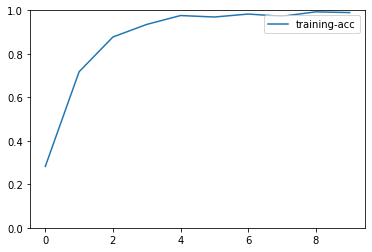

In [ ]:
epochs = 10
lr_decay_count = 0

for epoch in range(epochs):
    tic = time.time()
    train_metric.reset()
    train_loss = 0

    # Learning rate decay
    if epoch == lr_decay_epoch[lr_decay_count]:
        trainer.set_learning_rate(trainer.learning_rate*lr_decay)
        lr_decay_count += 1

    # Loop through each batch of training data
    for i, batch in enumerate(train_data):
        # Extract data and label
        data = split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        # AutoGrad
        with ag.record():
            output = []
            for _, X in enumerate(data):
                X = X.reshape((-1,) + X.shape[2:])
                pred = net(X)
                output.append(pred)
            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]

        # Backpropagation
        for l in loss:
            l.backward()

        # Optimize
        trainer.step(batch_size)

        # Update metrics
        train_loss += sum([l.mean().asscalar() for l in loss])
        train_metric.update(label, output)

        if i == 100:
            break

    name, acc = train_metric.get()

    # Update history and print metrics
    train_history.update([acc])
    print('[Epoch %d] accuracy= %f loss= %f time: %f' %
        (epoch, acc, train_loss / (i+1), time.time()-tic))

# We can plot the metric scores with:
train_history.plot()

**8. Saving the model**

In [ ]:
net.save_parameters('Model/i3d_resnet50_v1.params')

**9. Running my infrence**

In [ ]:
# Map
CLASS_MAP = {
    0: "Opaque",
    1: "Red",
    2: "Green",
    3: "Yellow",
    4: "Bright",
    5: "Light-blue"
}

In [ ]:
from gluoncv.utils.filesystem import try_import_decord
decord = try_import_decord()

video_fname = 'DataSet/train/006_002_001.mp4'
vr = decord.VideoReader(video_fname)
frame_id_list = range(0, 64, 2)
video_data = vr.get_batch(frame_id_list).asnumpy()
clip_input = [video_data[vid, :, :, :] for vid, _ in enumerate(frame_id_list)]

transform_fn = video.VideoGroupValTransform(size=(224, 224), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
clip_input = transform_fn(clip_input)
clip_input = np.stack(clip_input, axis=0)
clip_input = clip_input.reshape((-1,) + (32, 3, 224, 224))
clip_input = np.transpose(clip_input, (0, 2, 1, 3, 4))
print('Video data is readed and preprocessed.')

Video data is readed and preprocessed.


In [ ]:
# Running the prediction
pred = net(nd.array(clip_input,  ctx = mx.gpu(0)))
topK = 5
ind = nd.topk(pred, k=topK)[0].astype('int')
print('The input video clip is classified to be')
for i in range(topK):
    print('\t[%s], with probability %.3f.'%
          (CLASS_MAP[ind[i].asscalar()], nd.softmax(pred)[0][ind[i]].asscalar()))

The input video clip is classified to be
	[Yellow], with probability 0.554.
	[Red], with probability 0.124.
	[Bright], with probability 0.118.
	[Light-blue], with probability 0.098.
	[Green], with probability 0.059.
